In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

baseFigPath='fig/analysis_A20/'

In [2]:
def run():

    cases0=[
        [(0,0,0,0,0,0),'tt',1],
    ]

    cases1=[
        [(1,0,0,0,0,0),'tx',1],[(-1,0,0,0,0,0),'tx',-1],
        [(0,1,0,0,0,0),'ty',1],[(0,-1,0,0,0,0),'ty',-1],
        [(0,0,1,0,0,0),'tz',1],[(0,0,-1,0,0,0),'tz',-1],
    ]

    projs=['P0', 'Px', 'Py', 'Pz']
    inserts=['tt', 'tx', 'ty', 'tz', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']
    stouts_all=range(0,40+1)

    outpath='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    with h5py.File(outpath,'w') as fw:
        for ens in enss:
            path=f'dataPrepare/{ens2full[ens]}/data_aux/cfgs_run'
            with open(path,'r') as f:
                cfgs=f.read().splitlines()
            
            path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/{ens2label[ens]}.h5'
            with h5py.File(path) as f:
                for key in f['data'].keys():
                    t=f['data'][key][:]
                    t=t[:,:,0,projs.index('P0'),inserts.index('tt')]
                    fw.create_dataset(f'{ens}/mom0/{key}',data=t)
            
            # vev
            key2data={}
            path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test2.h5'
            with h5py.File(path) as f:
                for j in f.keys():
                    if not j.startswith('j'):
                        continue
                    for key in f[j].keys():
                        if key.endswith('vev'):
                            fw.create_dataset(f'{ens}/vev/{j}',data=f[j][key][:])
            
            # mom0
            key2data={}
            for icfg,cfg in enumerate(cfgs):
                
                print(f'{ens}: {icfg}/{len(cfgs)}',end='                \r')
                path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run1/{ens2full[ens]}/data_avgsrc/{cfg}/'
                
                file=f'{path}N.h5'
                with h5py.File(file) as f:
                    moms=f['moms'][:]
                    dic={}
                    for i,mom in enumerate(moms):
                        dic[tuple(mom)]=i
                        
                    imoms1=[dic[mom[:3]] for mom,insert,factor in cases0]
                    
                    t=f['data']['N_N'][:]
                    t=t[:,imoms1]
                    
                    key='N'
                    if key not in key2data:
                        key2data[key]=[]
                    key2data[key].append(t) 
                                    
                for j in ['j+','js','jc']:
                    file=f'{path}discNJN_{j};g{{m,Dn}};tl.h5'
                    with h5py.File(file) as f:
                        moms=f['moms'][:]
                        dic={}
                        for i,mom in enumerate(moms):
                            dic[tuple(mom)]=i
                        
                        iproj=projs.index('P0')
                        
                        imoms1=[dic[mom] for mom,insert,factor in cases0]
                        iins1=[inserts.index(insert) for mom,insert,factor in cases0]
                        factors1=np.array([factor for mom,insert,factor in cases0])
                        
                        for fla in f['data'].keys():
                            tf=int(fla.split('_')[-1])
                            t=f['data'][fla][:]
                            t=t[:,imoms1,iproj,iins1]
                            t=t*factors1[None,:]
                            
                            key=f'{j};disc_{tf}'
                            if key not in key2data:
                                key2data[key]=[]
                            key2data[key].append(t) 
                
                file=f'{path}discNJN_jg;stout.h5'
                with h5py.File(file) as f:
                    moms=f['moms'][:]
                    dic={}
                    for i,mom in enumerate(moms):
                        dic[tuple(mom)]=i
                        
                    iproj=projs.index('P0')
                    
                    imoms1=[dic[mom] for mom,insert,factor in cases0]
                    iins1=[inserts.index(insert) for mom,insert,factor in cases0]
                    factors1=np.array([factor for mom,insert,factor in cases0])
                        
                    for fla in f['data'].keys():
                        stout=int(fla.split('_')[-2].split('stout')[-1])
                        tf=int(fla.split('_')[-1])
                        t=f['data'][fla][:]
                        t=t[:,imoms1,iproj,iins1]
                        t=t*factors1[None,:]
                        
                        key=f'jg;stout{stout};disc_{tf}'
                        if key not in key2data:
                            key2data[key]=[]
                        key2data[key].append(t) 
            
            for key in key2data.keys():
                key2data[key]=np.array(key2data[key])
                fw.create_dataset(f'{ens}/mom0/{key}',data=key2data[key])
            
            # mom1
            key2data={}
            for icfg,cfg in enumerate(cfgs):
                
                print(f'{ens}: {icfg}/{len(cfgs)}',end='                \r')
                path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run1/{ens2full[ens]}/data_avgsrc/{cfg}/'
                
                file=f'{path}N.h5'
                with h5py.File(file) as f:
                    moms=f['moms'][:]
                    dic={}
                    for i,mom in enumerate(moms):
                        dic[tuple(mom)]=i
                        
                    imoms1=[dic[mom[:3]] for mom,insert,factor in cases1]
                    
                    t=f['data']['N_N'][:]
                    t=t[:,imoms1]
                    
                    key='N'
                    if key not in key2data:
                        key2data[key]=[]
                    key2data[key].append(t) 
                                    
                for j in ['j+','js','jc']:
                    file=f'{path}discNJN_{j};g{{m,Dn}};tl.h5'
                    with h5py.File(file) as f:
                        moms=f['moms'][:]
                        dic={}
                        for i,mom in enumerate(moms):
                            dic[tuple(mom)]=i
                        
                        iproj=projs.index('P0')
                        
                        imoms1=[dic[mom] for mom,insert,factor in cases1]
                        iins1=[inserts.index(insert) for mom,insert,factor in cases1]
                        factors1=np.array([factor for mom,insert,factor in cases1])
                        
                        for fla in f['data'].keys():
                            tf=int(fla.split('_')[-1])
                            t=f['data'][fla][:]
                            t=t[:,imoms1,iproj,iins1]
                            t=t*factors1[None,:]
                            
                            key=f'{j};disc_{tf}'
                            if key not in key2data:
                                key2data[key]=[]
                            key2data[key].append(t) 
                
                file=f'{path}discNJN_jg;stout.h5'
                with h5py.File(file) as f:
                    moms=f['moms'][:]
                    dic={}
                    for i,mom in enumerate(moms):
                        dic[tuple(mom)]=i
                        
                    iproj=projs.index('P0')
                    
                    imoms1=[dic[mom] for mom,insert,factor in cases1]
                    iins1=[inserts.index(insert) for mom,insert,factor in cases1]
                    factors1=np.array([factor for mom,insert,factor in cases1])
                        
                    for fla in f['data'].keys():
                        stout=int(fla.split('_')[-2].split('stout')[-1])
                        tf=int(fla.split('_')[-1])
                        t=f['data'][fla][:]
                        t=t[:,imoms1,iproj,iins1]
                        t=t*factors1[None,:]
                        
                        key=f'jg;stout{stout};disc_{tf}'
                        if key not in key2data:
                            key2data[key]=[]
                        key2data[key].append(t) 
            
            for key in key2data.keys():
                key2data[key]=np.array(key2data[key])
                fw.create_dataset(f'{ens}/mom1/{key}',data=key2data[key])
                
# run()

In [3]:
def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

def doFit(ens2dat,keys,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,keys)
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(keys):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.5)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(1,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=1
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut-2]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
            
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    
    for iens,ens in enumerate(keys):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
    
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/6dir_rainbow.pdf')
    plt.close()
    
    fig, axs = yu.getFigAxs(1,3,sharey=True)
    ax=axs[0,0]
    ax.set_xlabel('MA_values')
    ax.set_xticks(range(len(keys)+1))
    for ikey,key in enumerate(keys):
        mean,err=yu.jackme(key2res[key])
        plt_x=(ikey)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='r') 
    mean,err=yu.jackme(np.mean([key2res[key] for key in keys[:6]],axis=0))
    plt_x=len(keys)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r') 
        
    ax=axs[0,1]
    tf=2; tc=1
    ax.set_xlabel(f'tf={tf},tc={tc}')
    ax.set_xticks(range(len(keys)))
    for ikey,key in enumerate(keys):
        mean,err=yu.jackme(ens2dat[key][tf][:,tc])
        plt_x=(ikey)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='r') 
        
    ax=axs[0,2]
    tf=10; tc=5
    ax.set_xlabel(f'tf={tf},tc={tc}')
    ax.set_xticks(range(len(keys)))
    for ikey,key in enumerate(keys):
        mean,err=yu.jackme(ens2dat[key][tf][:,tc])
        plt_x=(ikey)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color='r') 
    
    plt.tight_layout()
    # plt.savefig(f'{baseFigPath}/6dir_compare.pdf')
    plt.close()
    
ens='b'
# key='j+;disc'
key='jg;stout10;disc'
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
# path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
with h5py.File(path) as f:
    cN=yu.jackknife(np.real(f[ens]['mom1']['N'][:]))
    tfs_all=range(2,22+1)
    tf2c3pt={tf:yu.jackknife(np.real(f[ens]['mom1'][f'{key}_{tf}'][:]/(1j*2*np.pi/ens2N[ens]))) for tf in tfs_all}
    tf2ratio={tf:tf2c3pt[tf]/cN[:,tf:tf+1,:] for tf in tfs_all}
    
    keys=[f'b_{i}' for i in range(1,7)]+['b_avgBratio','b_avgAratio']
    ens2dat={f'b_{i}':{tf:tf2ratio[tf][:,:,i-1] for tf in tfs_all} for i in range(1,7)}
    ens2dat['b_avgBratio']={tf:np.mean(tf2c3pt[tf],axis=-1)/np.mean(cN[:,tf:tf+1,:],axis=-1) for tf in tfs_all}
    ens2dat['b_avgAratio']={tf:np.mean(tf2c3pt[tf]/cN[:,tf:tf+1,:],axis=-1) for tf in tfs_all}
    
    print(np.mean(ens2dat['b_avgBratio'][2],axis=0))
    print(np.mean(ens2dat['b_avgAratio'][2],axis=0))
    
    tt=[]
    for key in keys:
        t=yu.jackme(ens2dat[key][10][:,5])
        tt.append(t[1])
    print((tt/tt[-1])**2)
    
    # doFit(ens2dat,keys,'',symmetrizeQ=True)
    
    mean,err=yu.jackme(ens2dat['b_avgBratio'][6])
    print(mean)
    # print(t/[0.07424376, 0.04888412, 0.00529571, 0.03187858, 0.08821541,
    #    0.09965172, 0.01504364])

[0.14152632 0.17558212 0.13092772]
[0.14152664 0.17558222 0.13092806]
[11.85976967 12.72932836 13.76873465 12.32303077 12.63261364 13.65555904
  0.99997775  1.        ]
[0.16305502 0.26933696 0.34403634 0.36609884 0.34732906 0.27375783
 0.16030922]


In [4]:
data={}
for ens in enss:
    # path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/{ens2full[ens]}/data_merge/data.h5'
    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    with h5py.File(path) as f:        
        data[ens]=yu.jackknife(np.real(f[f'{ens}/mom0/N'][:,:,0])) 

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # plt.savefig(figname)
    plt.close()
    return res

res_c2ptN0={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN0[ens]=run(ens,figname=f'{baseFigPath}fig_ignore/c2ptN0_{ens}.pdf')
    
ens2mN={}
for ens in enss:
    ens2mN[ens]=res_c2ptN0[ens][:,0]

In [5]:
data={}
for ens in enss:
    # path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run2/{ens2full[ens]}/data_merge/data.h5'
    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    with h5py.File(path) as f:        
        data[ens]=yu.jackknife(np.mean(np.real(f[f'{ens}/mom1/N'][:,:,:]),axis=-1)) 

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # plt.savefig(figname)
    plt.close()
    return res

res_c2ptN1={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN1[ens]=run(ens,figname=f'{baseFigPath}fig_ignore/c2ptN0_{ens}.pdf')

In [6]:
ens2Njk={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run2/{ens2full[ens]}/data_merge/data.h5'
    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    with h5py.File(path) as f:        
        ens2Njk[ens]=len(f[f'{ens}/mom0/N'])

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]

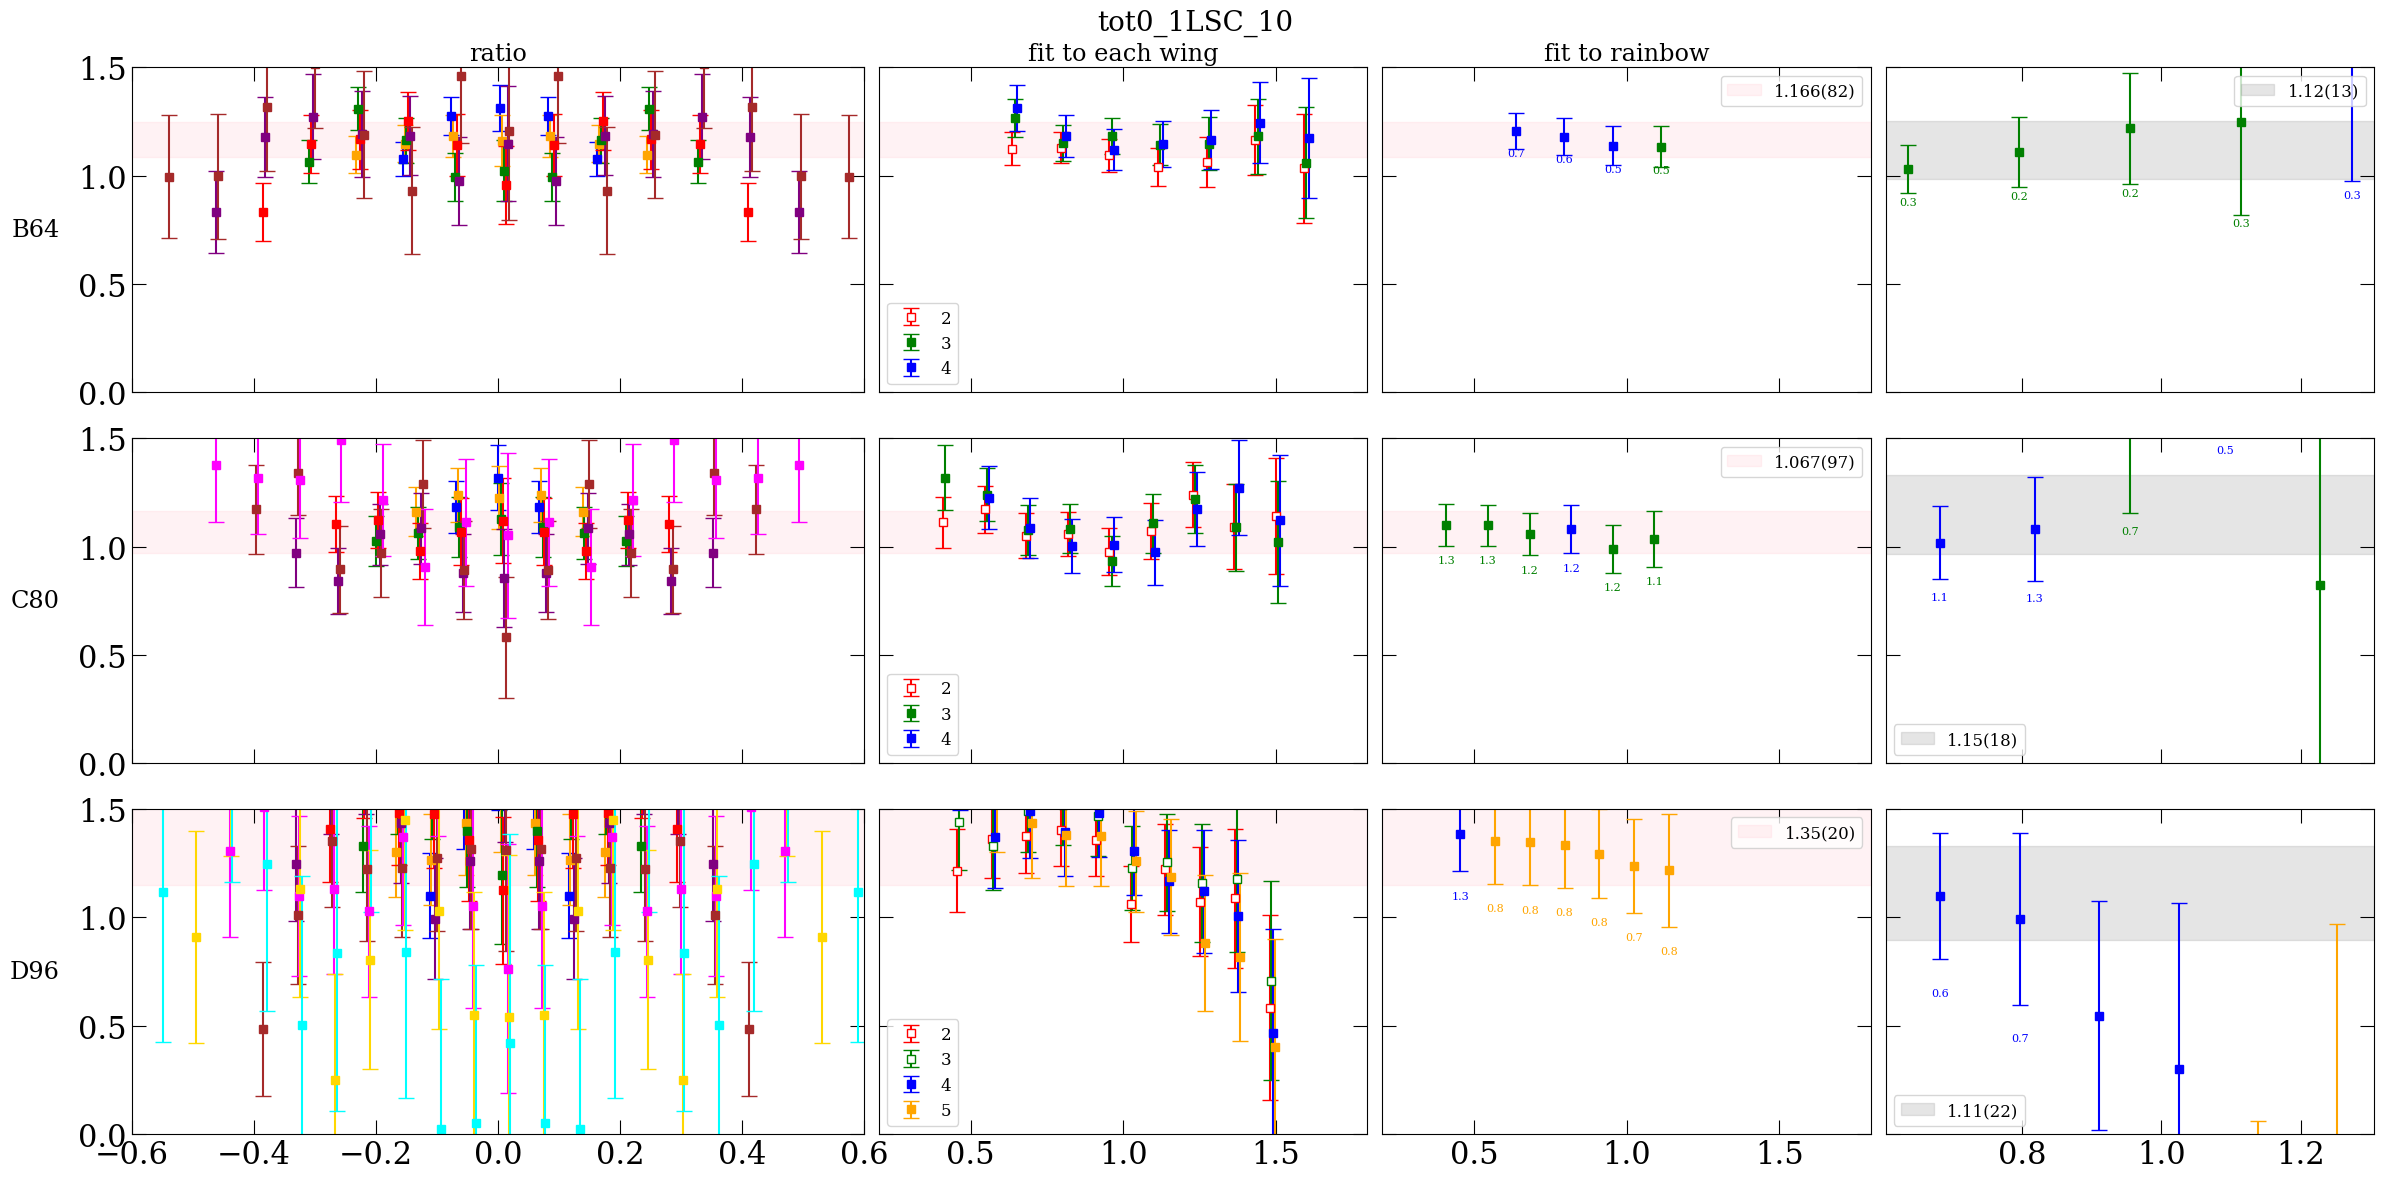

In [14]:
def doFit(ens2dat,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    axs[0,0].set_ylim([0,1.5])
    # axs[0,0].set_ylim([0.2,0.8])
    # axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
            
    plt.tight_layout()
    # plt.savefig(f'{baseFigPath}/{title}.pdf')
    # plt.close()

# stouts=[5,10,15,20,30,40]
stouts=[10]
for stout in stouts:
    print(stout,end='             \r')
    path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    # path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
    with h5py.File(path) as f:
        ens2dat={}
        for ens in enss:
            cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
            
            cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
            
            t=f[ens]['mom0'].keys()
            t=[int(key.split('_')[-1]) for key in t if key.startswith('j+;conn')]
            tfs=list(set(t)); tfs.sort()
            
            def get(tf):
                
                factor=1/(-3*res_c2ptN0[ens][:,0]/4)
                factor1=1/(1j*2*np.pi/ens2N[ens])
                
                t1=np.real(yu.jackknife(f[ens]['mom0'][f'j+;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
                
                t2=np.real(yu.jackknife(f[ens]['mom0'][f'j+;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['j+'][:])*factor)
                t2 -= (cN[:,tf]*tvev)[:,None]
                t2 = t2/cN[:,tf:tf+1]
                t2_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'j+;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t3=np.real(yu.jackknife(f[ens]['mom0'][f'js;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['js'][:])*factor)
                t3 -= (cN[:,tf]*tvev)[:,None]
                t3 = t3/cN[:,tf:tf+1]
                t3_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'js;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t4=np.real(yu.jackknife(f[ens]['mom0'][f'jc;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['jc'][:])*factor)
                t4 -= (cN[:,tf]*tvev)[:,None]
                t4 = t4/cN[:,tf:tf+1]
                t4_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jc;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t5=np.real(yu.jackknife(f[ens]['mom0'][f'jg;stout{stout};disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev'][f'jg;stout{stout}'][:])*factor)
                t5 -= (cN[:,tf]*tvev)[:,None]
                t5 = t5/cN[:,tf:tf+1]
                t5_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jg;stout{stout};disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]

                # tq=(t1+t2+t3+t4)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + t5*ens2RCs[ens]['Zqg(mu=nu)'][:,None]
                # tg=t5*ens2RCs[ens][f'Zgg^{stout}(mu=nu)'][:,None] + (t1+t2+t3+t4)*ens2RCs[ens]['Zgq(mu=nu)'][:,None]
                
                # tq=(t1+t2)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + t5*ens2RCs[ens]['Zqg(mu=nu)'][:,None]
                # tg=t5*ens2RCs[ens][f'Zgg^{stout}(mu=nu)'][:,None] + (t1+t2)*ens2RCs[ens]['Zgq(mu=nu)'][:,None]
                
                # tq=(t1+t2)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + (t3_1+t4_1)*ens2RCs[ens]['Zqq(mu!=nu)'][:,None] + t5*ens2RCs[ens]['Zqg(mu=nu)'][:,None]
                # tg=t5*ens2RCs[ens][f'Zgg^{stout}(mu=nu)'][:,None] + (t1+t2)*ens2RCs[ens]['Zgq(mu=nu)'][:,None] + (t3_1+t4_1)*ens2RCs[ens]['Zgq(mu!=nu)'][:,None]
                
                tq=(t1)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + (t2_1+t3_1+t4_1)*ens2RCs[ens]['Zqq(mu!=nu)'][:,None] + t5*ens2RCs[ens]['Zqg(mu=nu)'][:,None]
                tg=t5*ens2RCs[ens][f'Zgg^{stout}(mu=nu)'][:,None] + (t1)*ens2RCs[ens]['Zgq(mu=nu)'][:,None] + (t2_1+t3_1+t4_1)*ens2RCs[ens]['Zgq(mu!=nu)'][:,None]
                
                # tq=(t1)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + (t2_1+t3_1+t4_1)*ens2RCs[ens]['Zqq(mu!=nu)'][:,None] + t5_1*ens2RCs[ens]['Zqg(mu!=nu)'][:,None]
                # tg=t5_1*ens2RCs[ens][f'Zgg^{stout}(mu!=nu)'][:,None] + (t1)*ens2RCs[ens]['Zgq(mu=nu)'][:,None] + (t2_1+t3_1+t4_1)*ens2RCs[ens]['Zgq(mu!=nu)'][:,None]
                
                # tq=(t1)*ens2RCs[ens]['Zqq(mu=nu)'][:,None] + (t2_1)*ens2RCs[ens]['Zqq(mu!=nu)'][:,None] + t5_1*ens2RCs[ens]['Zqg(mu!=nu)'][:,None]
                # tg=t5_1*ens2RCs[ens][f'Zgg^{stout}(mu!=nu)'][:,None] + (t1)*ens2RCs[ens]['Zgq(mu=nu)'][:,None] + (t2_1)*ens2RCs[ens]['Zgq(mu!=nu)'][:,None]
                
                return tq+tg
            
            tf2ratio={tf:get(tf) for tf in tfs}
            
            ens2dat[ens]=tf2ratio
            
        doFit(ens2dat,f'tot0_1LSC_{stout}')

In [7]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

def doFit(ens2dat,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
                
        # 2st fit
        ax=axs[i_ens,4]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
                tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
                y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
                def fitfunc(pars):
                    g,ra01,ra11, E0,dE1,rc1=pars
                    t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [4]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==4:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
        
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    # axs[0,0].set_ylim([0,1.5])
    axs[0,0].set_ylim([0.2,0.8])
    axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
            
    plt.tight_layout()
    # plt.savefig(f'{baseFigPath}/{title}.pdf')
    # plt.close()

path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
# path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
with h5py.File(path) as f:
    ens2dat={}
    for ens in enss:
        cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
        cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
        t=f[ens]['mom0'].keys()
        t=[int(key.split('_')[-1]) for key in t if key.startswith('j+;conn')]
        tfs=list(set(t)); tfs.sort()
        
        def get(tf):
            factor=1/(-3*res_c2ptN0[ens][:,0]/4)
            t1=np.real(yu.jackknife(f[ens]['mom0'][f'j+;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
            return t1
        
        tf2ratio={tf:get(tf) for tf in tfs}
        
        ens2dat[ens]=tf2ratio
        
    # doFit(ens2dat,'rainbow_j+;conn')

#==== example plots

In [32]:
# conn

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

enss=['b']
def doFit(ens2dat,title,symmetrizeQ=True):
    
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    ens2results={}
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
        
        results={}
        results['tf2ratio']=tf2ratio
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        results['fits_const']=fits
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        results['fits_sum']=fits
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
                
        # 2st fit
        ax=axs[i_ens,4]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
                tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
                y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
                def fitfunc(pars):
                    g,ra01,ra11, E0,dE1,rc1=pars
                    t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        results['fits_2st']=fits
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [4]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==4:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
    
        ens2results[ens]=results
        plt.close()
    return ens2results

case2ens2results={}
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
with h5py.File(path) as f:
    ens2dat={}
    for ens in enss:
        cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
        cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
        t=f[ens]['mom0'].keys()
        t=[int(key.split('_')[-1]) for key in t if key.startswith('j+;conn')]
        tfs=list(set(t)); tfs.sort()
        
        def get(tf):
            factor=1/(-3*res_c2ptN0[ens][:,0]/4)
            t1=np.real(yu.jackknife(f[ens]['mom0'][f'j+;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
            return t1
        
        tf2ratio={tf:get(tf) for tf in tfs}
        
        ens2dat[ens]=tf2ratio
        
    case2ens2results['j+;conn']=doFit(ens2dat,'rainbow_j+;conn')
    
    ens2dat={}
    for ens in enss:
        cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
        cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
        t=f[ens]['mom0'].keys()
        t=[int(key.split('_')[-1]) for key in t if key.startswith('j-;conn')]
        tfs=list(set(t)); tfs.sort()
        
        def get(tf):
            factor=1/(-3*res_c2ptN0[ens][:,0]/4)
            t1=np.real(yu.jackknife(f[ens]['mom0'][f'j-;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
            return t1
        
        tf2ratio={tf:get(tf) for tf in tfs}
        
        ens2dat[ens]=tf2ratio
        
    case2ens2results['j-;conn']=doFit(ens2dat,'rainbow_j-;conn')

In [34]:
# conn

def run(cases):
    ens='b'
    fig, axs = yu.getFigAxs(len(cases),4,Lrow=4,Lcol=6,sharex='col',sharey='row', gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    xunit=ens2a[ens]; yunit=1
    
    irow=-1
    axs[irow,0].set_xlabel(r'$t_{\rm ins}-t_{s}/2$ [fm]')        
    axs[irow,1].set_xlabel(r'$t_{s}^{\rm}$ [fm]')
    axs[irow,2].set_xlabel(r'$t_{s}^{\rm low}$ [fm]')
    axs[irow,3].set_xlabel(r'Fit Prob.')
    
    colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
    
    for icase,case in enumerate(cases):
        irow=icase
        xlims=[[-0.65,0.65],[0.45,1.8],[0.45,1.8]]
        for icol in range(3):
            axs[irow,icol].set_xlim(xlims[icol])
            
        ylabel={'j+;conn':r'$\langle x \rangle_{u+d}^{\rm B}$ (conn)', 'j-;conn':r'$\langle x \rangle_{u-d}^{\rm B}$ (conn)'}[case]

        axs[irow,0].set_ylabel(ylabel)

        results=case2ens2results[case][ens]

        tf2ratio=results['tf2ratio']
        tfs_all=list(tf2ratio.keys()); tfs_all.sort()

        ax=axs[irow,0]
        t_cut=2
        for i_tf,tf in enumerate(tfs_all):
            ratio=tf2ratio[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
        ax=axs[irow,1]
        for i_tf,tf in enumerate(tfs_all):
            ratio=tf2ratio[tf][:,tf//2]
            mean,err=yu.jackme(ratio)
            plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)

        ax=axs[irow,2]
        fits=results['fits_2st']
        tcmins=list(set([fit[0][0] for fit in fits])); tcmins.sort()
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        pars_jk,props_jk=yu.jackMA(fits)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        fitlabel_mpf=fits[ind_mpf][0]
        for i_tfmin,tfmin in enumerate(tfmins):
            tfits=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(tfits)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            
            (tcmin,tfmin),pars_jk,chi2_jk,Ndof=tfits[ind_mpf]
            mean,err=yu.jackme(pars_jk)
            
            plt_x=(tfmin)*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white' if (tcmin,tfmin)==fitlabel_mpf else None) 

        pars_jk,props_jk=yu.jackMA(fits)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fits[ind_mpf]
        ax=axs[irow,0]
        t_cut=tcmin
        for i_tf,tf in enumerate(tfs_all):
            if tf<tfmin:
                continue
            tcs=np.arange(t_cut,tf-t_cut,0.1)
            t=np.array([func_ratio_2st(tf,tcs,pars[0],pars_2pt[1],pars_2pt[2],pars[1],pars[2]) for pars, pars_2pt in zip(pars_jk,res_c2ptN0[ens])])
            mean,err=yu.jackme(t)
            plt_x=(tcs-tf//2)*xunit; plt_y=mean*yunit; plt_err=err*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=colors[i_tf],alpha=0.2)   
        ax=axs[irow,1]
        tfs=np.arange(ax.get_xlim()[0]/xunit,ax.get_xlim()[1]/xunit,0.1)
        t=np.array([func_ratio_2st(tfs,tfs/2,pars[0],pars_2pt[1],pars_2pt[2],pars[1],pars[2]) for pars, pars_2pt in zip(pars_jk,res_c2ptN0[ens])])
        mean,err=yu.jackme(t)
        plt_x=tfs*xunit; plt_y=mean*yunit; plt_err=err*yunit
        ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)   

        ax=axs[irow,3]
        xticks=[1,3,10,30]
        ax.set_xlim([xticks[0]/2,xticks[-1]*3])
        ax.set_xscale('log')
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{x}%' for x in xticks])
        pars_jk,props_jk=yu.jackMA(fits)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fits[ind_mpf]
        for ifit, fit in enumerate(fits):
            (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fit
            prop=np.mean(props_jk,axis=0)[ifit]
            if prop<1/100:
                continue
            mean,err=yu.jackme(pars_jk)
            plt_x=(prop)*100; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white' if (tcmin,tfmin)==fitlabel_mpf else None) 

        pars_jk,props_jk=yu.jackMA(fits)
        mean,err=yu.jackme(pars_jk)
        for icol in [0,1,2,3]:
            ax=axs[irow,icol]
            plt_x=ax.get_xlim(); plt_y=mean[0]*yunit; plt_err=err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='red',alpha=0.2)  
            
        print(plt_y,plt_err)

    plt.tight_layout()
    plt.savefig(f'fig/analysis_A20/examplePlots/examplePlot_conn.pdf',bbox_inches="tight")
    plt.close()
    
run(['j+;conn','j-;conn'])

0.38678960392261535 0.020362058475249866
0.15831641725889353 0.01147554485793688


In [ ]:
[0.38678960392261535, 0.020362058475249866
0.15831641725889353, 0.01147554485793688]

np.mean(ens2RCs['b']['Zqq(mu=nu)'])*np.array([0.15831641725889353, 0.01147554485793688])

array([0.17679194, 0.01281474])

In [35]:
# disc

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

enss=['b']
def doFit(ens2dat,title,symmetrizeQ=True):
    
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    ens2results={}
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
        
        results={}
        results['tf2ratio']=tf2ratio
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        results['fits_const']=fits
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        results['fits_sum']=fits
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
                
        # 2st fit
        # ax=axs[i_ens,4]
        # fits=[]
        # for i_tcmin, tcmin in enumerate(tcmins):
        #     tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
        #     for tfmin in tfmins:
        #         if tfmin<tcmin*2:
        #             continue
                
        #         tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
        #         tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
        #         y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
        #         def fitfunc(pars):
        #             g,ra01,ra11, E0,dE1,rc1=pars
        #             t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
        #             return t
        #         pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
        #         fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        # results['fits_2st']=fits
                
        # tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        # for tfmin in tfmins:
        #     t=[fit for fit in fits if fit[0][1]==tfmin]
        #     pars_jk,props_jk=yu.jackMA(t)
        #     ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        #     fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
        #     i_tcmin=tcmins.index(fitlabel[0])
            
        #     mean,err=yu.jackme(pars_jk[:,0])
        #     plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        #     i_tf=tfs.index(tfmin)
        #     ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
        #     chi2R=np.mean(chi2_jk)/Ndof
        #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
        #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        # pars_jk,props_jk=yu.jackMA(fits)
        # pars_mean,pars_err=yu.jackme(pars_jk)
        # for icol in [4]:
        #     ax.set_xlim(ax.get_xlim())
        #     ax=axs[i_ens,icol]
            
        #     plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
        #     if icol==4:
        #         # print(ens,yu.un2str(plt_y,plt_err))
        #         ax.legend(fontsize=12)         
    
        ens2results[ens]=results
        plt.close()
    return ens2results

case2ens2results={}
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
enss=['b']
with h5py.File(path) as f:
    stout=10
    for case in ['j+','js','jc','jg']:
        ens2dat={}
        for ens in enss:
            cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
            cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
            
            t=f[ens]['mom1'].keys()
            t=[int(key.split('_')[-1]) for key in t if key.startswith('j+')]
            tfs=list(set(t)); tfs.sort()
            
            def get(tf):
                
                factor=1/(-3*res_c2ptN0[ens][:,0]/4)
                factor1=1/(1j*2*np.pi/ens2N[ens])
                
                t2=np.real(yu.jackknife(f[ens]['mom0'][f'j+;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['j+'][:])*factor)
                t2 -= (cN[:,tf]*tvev)[:,None]
                t2 = t2/cN[:,tf:tf+1]
                t2_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'j+;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t3=np.real(yu.jackknife(f[ens]['mom0'][f'js;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['js'][:])*factor)
                t3 -= (cN[:,tf]*tvev)[:,None]
                t3 = t3/cN[:,tf:tf+1]
                t3_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'js;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t4=np.real(yu.jackknife(f[ens]['mom0'][f'jc;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['jc'][:])*factor)
                t4 -= (cN[:,tf]*tvev)[:,None]
                t4 = t4/cN[:,tf:tf+1]
                t4_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jc;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t5=np.real(yu.jackknife(f[ens]['mom0'][f'jg;stout{stout};disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev'][f'jg;stout{stout}'][:])*factor)
                t5 -= (cN[:,tf]*tvev)[:,None]
                t5 = t5/cN[:,tf:tf+1]
                t5_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jg;stout{stout};disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                return {'j+':t2_1,'js':t3_1,'jc':t4_1,'jg':t5_1}[case]
            
            tf2ratio={tf:get(tf) for tf in tfs}
            
            ens2dat[ens]=tf2ratio
            
        case2ens2results[case]=doFit(ens2dat,'')

In [36]:
# disc
def run(cases):
    ens='b'
    fig, axs = yu.getFigAxs(len(cases),4,Lrow=4,Lcol=6,sharex='col',sharey='row', gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    xunit=ens2a[ens]; yunit=1
    
    irow=-1
    axs[irow,0].set_xlabel(r'$t_{\rm ins}-t_{s}/2$ [fm]')        
    axs[irow,1].set_xlabel(r'$t_{s}^{\rm}$ [fm]')
    axs[irow,2].set_xlabel(r'$t_{s}^{\rm low}$ [fm]')
    axs[irow,3].set_xlabel(r'Fit Prob.')
    
    colors=['b','orange','g','r','cyan','brown','magenta','gold','purple','grey','skyblue','pink','olive','lime']
    
    for icase,case in enumerate(cases):
        irow=icase
        xlims=[[-0.55,0.55],[0.1,1.4],[0.1,1.4]]
        for icol in range(3):
            axs[irow,icol].set_xlim(xlims[icol])
            
        ylabel={'jg':r'$\langle x \rangle_{g}^{\rm B}$ (disc)',
                'j+':r'$\langle x \rangle_{u+d}^{\rm B}$ (disc)',
                'js':r'$\langle x \rangle_{s}^{\rm B}$ (disc)',
                'jc':r'$\langle x \rangle_{c}^{\rm B}$ (disc)',
                }[case]
        ylim={
            'jg':[0.2,0.6],
            'j+':[0,0.2],
            'js':[-0.05,0.1],
            'jc':[-0.05,0.05],
        }[case[:2]]

        axs[irow,0].set_ylabel(ylabel)
        axs[irow,0].set_ylim(ylim)

        results=case2ens2results[case][ens]

        tf2ratio=results['tf2ratio']
        tfs_all=list(tf2ratio.keys()); tfs_all.sort()
        tfs_rainbow=[tf for tf in tfs_all if tf<12]
        tfs_mid=[tf for tf in tfs_all if tf<16]
        tfs_const=tfs_mid[4:-2]

        ax=axs[irow,0]
        t_cut=2
        for i_tf,tf in enumerate(tfs_rainbow):
            if tf%2!=0:
                continue
            ratio=tf2ratio[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
        ax=axs[irow,1]
        for i_tf,tf in enumerate(tfs_mid):
            ratio=tf2ratio[tf][:,tf//2]
            mean,err=yu.jackme(ratio)
            plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)

        ax=axs[irow,2]
        fits=results['fits_const']
        tcmins=list(set([fit[0][0] for fit in fits])); tcmins.sort()
        # tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        tfmins=tfs_const
        pars_jk,props_jk=yu.jackMA(fits)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        fitlabel_mpf=fits[ind_mpf][0]
        for i_tfmin,tfmin in enumerate(tfmins):
            tfits=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(tfits)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            
            (tcmin,tfmin),pars_jk,chi2_jk,Ndof=tfits[ind_mpf]
            mean,err=yu.jackme(pars_jk)
            
            plt_x=(tfmin)*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white' if (tcmin,tfmin)==fitlabel_mpf else None) 

        # pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        # (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fits[ind_mpf]
        # ax=axs[irow,0]
        # t_cut=tcmin
        # for i_tf,tf in enumerate(tfs_all):
        #     if tf<tfmin:
        #         continue
        #     tcs=np.arange(t_cut,tf-t_cut,0.1)
        #     t=np.array([func_ratio_2st(tf,tcs,pars[0],pars_2pt[1],pars_2pt[2],pars[1],pars[2]) for pars, pars_2pt in zip(pars_jk,res_c2ptN0[ens])])
        #     mean,err=yu.jackme(t)
        #     plt_x=(tcs-tf//2)*xunit; plt_y=mean*yunit; plt_err=err*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=colors[i_tf],alpha=0.2)   
        # ax=axs[irow,1]
        # tfs=np.arange(ax.get_xlim()[0]/xunit,ax.get_xlim()[1]/xunit,0.1)
        # t=np.array([func_ratio_2st(tfs,tfs/2,pars[0],pars_2pt[1],pars_2pt[2],pars[1],pars[2]) for pars, pars_2pt in zip(pars_jk,res_c2ptN0[ens])])
        # mean,err=yu.jackme(t)
        # plt_x=tfs*xunit; plt_y=mean*yunit; plt_err=err*yunit
        # ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)   

        ax=axs[irow,3]
        xticks=[1,3,10,30]
        ax.set_xlim([xticks[0]/2,xticks[-1]*3])
        ax.set_xscale('log')
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{x}%' for x in xticks])
        pars_jk,props_jk=yu.jackMA(fits)
        ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fits[ind_mpf]
        for ifit, fit in enumerate(fits):
            (tcmin,tfmin),pars_jk,chi2_jk,Ndof=fit
            prop=np.mean(props_jk,axis=0)[ifit]
            if prop<1/100:
                continue
            mean,err=yu.jackme(pars_jk)
            plt_x=(prop)*100; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='r',mfc='white' if (tcmin,tfmin)==fitlabel_mpf else None) 

        pars_jk,props_jk=yu.jackMA(fits)
        mean,err=yu.jackme(pars_jk)
        for icol in [0,1,2,3]:
            ax=axs[irow,icol]
            plt_x=ax.get_xlim(); plt_y=mean[0]*yunit; plt_err=err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='red',alpha=0.2)  

    plt.tight_layout()
    plt.savefig(f'fig/analysis_A20/examplePlots/examplePlot_disc.pdf',bbox_inches="tight")
    plt.close()
    
run(['j+','js','jc','jg'])

In [72]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

def doFit(ens2dat,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),2,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2]})
    # yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    # yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(2):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        
        tcmins=[3]
        tcmins_model=tcmins
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        # ax=axs[i_ens,1]
        # for i_tcmin, tcmin in enumerate(tcmins):
        #     flag=True
        #     for i_tf,tf in enumerate(tfs):
        #         # if tf<tcmin*2:
        #         #     continue
        #         ratio=tf2ratio[tf]
        #         if tf>=2*tcmin:
        #             if symmetrizeQ:
        #                 y_jk=ratio[:,tcmin:tf//2+1]
        #             else:
        #                 y_jk=ratio[:,tcmin:tf-tcmin+1]
        #             Ndata=y_jk.shape[1]
        #             def fitfunc(pars):
        #                 return list(pars)*Ndata
        #             pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
        #         else:
        #             continue
        #             # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
        #             # print(tf,pars_jk.shape)
                
        #         mean,err=yu.jackme(pars_jk)
        #         plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        #         ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
        #         flag=False
                
        ax=axs[i_ens,1]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
        #     chi2R=np.mean(chi2_jk)/Ndof
        #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
        #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        # key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        # ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        # ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf>18:
                continue
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            # if err[tf//2]>pars_err*5:
            #     continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf//2] if i_tf//2<len(colors) else None)
            
        for icol in [0,1]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='red',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # # summation method
        # ax=axs[i_ens,3]
        # fits=[]
        # for i_tcmin, tcmin in enumerate(tcmins):
        #     tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
        #     for tfmin in tfmins:
        #         tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
        #         y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
        #         def fitfunc(pars):
        #             g,c=pars
        #             t=np.array([g*tf+c for tf in tfs_fit])
        #             return t
        #         pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
        #         fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        # tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        # for tfmin in tfmins:
        #     t=[fit for fit in fits if fit[0][1]==tfmin]
        #     pars_jk,props_jk=yu.jackMA(t)
        #     ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        #     fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
        #     i_tcmin=tcmins.index(fitlabel[0])
            
        #     mean,err=yu.jackme(pars_jk[:,0])
        #     plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        #     i_tf=tfs.index(tfmin)
        #     ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
        #     chi2R=np.mean(chi2_jk)/Ndof
        #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
        #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        # pars_jk,props_jk=yu.jackMA(fits)
        # pars_mean,pars_err=yu.jackme(pars_jk)
        # for icol in [3]:
        #     ax.set_xlim(ax.get_xlim())
        #     ax=axs[i_ens,icol]
            
        #     plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
        #     if icol==3:
        #         # print(ens,yu.un2str(plt_y,plt_err))
        #         ax.legend(fontsize=12)         
                
        # # 2st fit
        # ax=axs[i_ens,1]
        # fits=[]
        # for i_tcmin, tcmin in enumerate(tcmins):
        #     tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
        #     for tfmin in tfmins:
        #         if tfmin<tcmin*2:
        #             continue
                
        #         tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
        #         tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
        #         y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
        #         def fitfunc(pars):
        #             g,ra01,ra11, E0,dE1,rc1=pars
        #             t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
        #             return t
        #         pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
        #         fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        # tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        # for tfmin in tfmins:
        #     t=[fit for fit in fits if fit[0][1]==tfmin]
        #     pars_jk,props_jk=yu.jackMA(t)
        #     ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        #     fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
        #     i_tcmin=tcmins.index(fitlabel[0])
            
        #     mean,err=yu.jackme(pars_jk[:,0])
        #     plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
        #     i_tf=tfs.index(tfmin)
        #     ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
        #     chi2R=np.mean(chi2_jk)/Ndof
        #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
        #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        # pars_jk,props_jk=yu.jackMA(fits)
        # pars_mean,pars_err=yu.jackme(pars_jk)
        # for icol in [0,1]:
        #     ax.set_xlim(ax.get_xlim())
        #     ax=axs[i_ens,icol]
            
        #     plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='red',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
        #     # if icol==2:
        #     #     # print(ens,yu.un2str(plt_y,plt_err))
        #     #     ax.legend(fontsize=12)         
        
        # t_cut=3
        # ax=axs[i_ens,0]
        # for i_tf,tf in enumerate(tfs):
        #     # if i_tf<1:
        #     #     continue
        #     if tf%2!=0 or tf>tfmax_cut:
        #         continue
        #     tcs=np.arange(t_cut,tf+1-t_cut,0.1)
        #     t=np.array([func_ratio_2st(tf,tcs,pars[0],pars_2pt[1],pars_2pt[2],pars[1],pars[2]) for pars, pars_2pt in zip(pars_jk,res_c2ptN0[ens])])
        #     mean,err=yu.jackme(t)
        #     plt_x=(tcs-tf//2)*xunit; plt_y=mean*yunit; plt_err=err*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=colors[i_tf],alpha=0.2)   
            
            
    # ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    # axs[0,0].set_ylim(ylim)
    # axs[0,0].set_ylim([0,1.5])
    axs[0,0].set_ylim([0,1.2])
    # axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(['b']):
        for icol in [1]:
            ax=axs[iens,icol]
            # ax.legend(fontsize=12)  
            
    axs[0,0].set_ylabel(r'$\langle x \rangle_{g}^{B}$')
    axs[0,0].set_xlabel(r'$t_{\mathrm{ins}}-t_{\mathrm{s}}/2$ [fm]')        
    axs[0,1].set_xlabel(r'$t_{\mathrm{s,min}}$ [fm]')
    axs[0,1].text(0.6,1.0,'constant fits',fontsize=25)
            
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/{title}.pdf',bbox_inches="tight")
    plt.close()

path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
# path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
stout=10
with h5py.File(path) as f:
    ens2dat={}
    for ens in ['b']:
        cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
    
        cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
        t=f[ens]['mom1'].keys()
        t=[int(key.split('_')[-1]) for key in t if key.startswith('j+')]
        tfs=list(set(t)); tfs.sort()
        
        def get(tf):
            
            factor=1/(-3*res_c2ptN0[ens][:,0]/4)
            factor1=1/(1j*2*np.pi/ens2N[ens])
            
            t2=np.real(yu.jackknife(f[ens]['mom0'][f'j+;disc_{tf}'][:,:,0])*factor[:,None])
            tvev=np.real(yu.jackknife(f[ens]['vev']['j+'][:])*factor)
            t2 -= (cN[:,tf]*tvev)[:,None]
            t2 = t2/cN[:,tf:tf+1]
            t2_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'j+;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
            
            t3=np.real(yu.jackknife(f[ens]['mom0'][f'js;disc_{tf}'][:,:,0])*factor[:,None])
            tvev=np.real(yu.jackknife(f[ens]['vev']['js'][:])*factor)
            t3 -= (cN[:,tf]*tvev)[:,None]
            t3 = t3/cN[:,tf:tf+1]
            t3_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'js;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
            
            t4=np.real(yu.jackknife(f[ens]['mom0'][f'jc;disc_{tf}'][:,:,0])*factor[:,None])
            tvev=np.real(yu.jackknife(f[ens]['vev']['jc'][:])*factor)
            t4 -= (cN[:,tf]*tvev)[:,None]
            t4 = t4/cN[:,tf:tf+1]
            t4_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jc;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
            
            t5=np.real(yu.jackknife(f[ens]['mom0'][f'jg;stout{stout};disc_{tf}'][:,:,0])*factor[:,None])
            tvev=np.real(yu.jackknife(f[ens]['vev'][f'jg;stout{stout}'][:])*factor)
            t5 -= (cN[:,tf]*tvev)[:,None]
            t5 = t5/cN[:,tf:tf+1]
            t5_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jg;stout{stout};disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
            
            return t5_1
        
        tf2ratio={tf:get(tf) for tf in tfs}
        
        ens2dat[ens]=tf2ratio
        
    doFit(ens2dat,'examplePlot_rainbow_jg;stout10')

====#

In [ ]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

def doFit(ens2dat,title,parsExtra_jk,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
                
        # 2st fit
        ax=axs[i_ens,4]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
                tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
                y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
                def fitfunc(pars):
                    g,ra01,ra11, E0,dE1,rc1=pars
                    t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=parsExtra_jk)
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [4]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==4:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
        
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    # axs[0,0].set_ylim([0,1.5])
    # axs[0,0].set_ylim([0.2,0.8])
    # axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
            
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/{title}.pdf')
    plt.close()
    
# stouts=[5,10,15,20,30,40]
stouts=[10]
for stout in stouts:
    print(stout,end='             \r')
    path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
    path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
    with h5py.File(path) as f:
        ens2dat={}
        for ens in enss:
            cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
            
            cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
            
            t=f[ens]['mom1'].keys()
            t=[int(key.split('_')[-1]) for key in t if key.startswith('j+')]
            tfs=list(set(t)); tfs.sort()
            
            def get(tf):
                
                factor=1/(-3*res_c2ptN0[ens][:,0]/4)
                factor1=1/(1j*2*np.pi/ens2N[ens])
                
                t2=np.real(yu.jackknife(f[ens]['mom0'][f'j+;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['j+'][:])*factor)
                t2 -= (cN[:,tf]*tvev)[:,None]
                t2 = t2/cN[:,tf:tf+1]
                t2_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'j+;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t3=np.real(yu.jackknife(f[ens]['mom0'][f'js;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['js'][:])*factor)
                t3 -= (cN[:,tf]*tvev)[:,None]
                t3 = t3/cN[:,tf:tf+1]
                t3_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'js;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t4=np.real(yu.jackknife(f[ens]['mom0'][f'jc;disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev']['jc'][:])*factor)
                t4 -= (cN[:,tf]*tvev)[:,None]
                t4 = t4/cN[:,tf:tf+1]
                t4_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jc;disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                t5=np.real(yu.jackknife(f[ens]['mom0'][f'jg;stout{stout};disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev'][f'jg;stout{stout}'][:])*factor)
                t5 -= (cN[:,tf]*tvev)[:,None]
                t5 = t5/cN[:,tf:tf+1]
                t5_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'jg;stout{stout};disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                return t5
            
            tf2ratio={tf:get(tf) for tf in tfs}
            
            ens2dat[ens]=tf2ratio
            
        # doFit(ens2dat,f'rainbow_jg;stout{stout}_mom0',res_c2ptN0[ens])


# fits to all

In [ ]:
1/0

In [ ]:
ens2bare={ens:{} for ens in enss}

In [13]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

def doFit(ens2dat,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    ens2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))    
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        ens2res[ens]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
                
        # 2st fit
        ax=axs[i_ens,4]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
                tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
                y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
                def fitfunc(pars):
                    g,ra01,ra11, E0,dE1,rc1=pars
                    t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        ens2res[ens]=pars_jk[:,0]
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [4]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==4:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
        
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    # axs[0,0].set_ylim([0,1.5])
    axs[0,0].set_ylim([0.2,0.8])
    axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
            
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/fig_ignore/{title}.pdf')
    plt.close()
    
    return ens2res

# path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
# path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
# with h5py.File(path) as f:
#     ens2dat={}
#     for ens in enss:
#         cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
#         cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
#         t=f[ens]['mom0'].keys()
#         t=[int(key.split('_')[-1]) for key in t if key.startswith('j+;conn')]
#         tfs=list(set(t)); tfs.sort()
        
#         def get(tf):
#             factor=1/(-3*res_c2ptN0[ens][:,0]/4)
#             t1=np.real(yu.jackknife(f[ens]['mom0'][f'j+;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
#             return t1
        
#         tf2ratio={tf:get(tf) for tf in tfs}
        
#         ens2dat[ens]=tf2ratio
    
#     label='mom0_j+;conn'
#     ens2res=doFit(ens2dat,label)
    
#     for ens in enss:
#         ens2bare[ens][label]=ens2res[ens]

In [14]:
def doFit(ens2dat,title,symmetrizeQ=False):
    if len(ens2dat)==0:
        return {}
    
    fig, axs = yu.getFigAxs(len(enss),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    ens2res={}
    ylims=[]
    for i_ens,ens in enumerate(enss):
        if ens not in ens2dat.keys():
            continue
        
        xunit=ens2a[ens]; yunit=1
        tf2ratio=ens2dat[ens]
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.5)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(1,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))     
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        ens2res[ens]=[pars_jk[:,0]]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=1
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut-2]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
            
        pars_jk,props_jk=yu.jackMA(fits)
        ens2res[ens].append(pars_jk[:,0])
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
    
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/fig_ignore/{title}.pdf')
    plt.close()
    
    return ens2res

stouts=range(0,40+1,2)
path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
with h5py.File(path) as f:
    
    js=['j+','js','jc'] + [f'jg;stout{stout}' for stout in stouts]
    # js=['jg;stout10']
    
    for j in js:
        break
        print(j,end='                \r')
        ens2dat={}
        for ens in enss:
            cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
            
            cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
            
            t=f[ens]['mom0'].keys()
            t=[int(key.split('_')[-1]) for key in t if key.startswith('js')]
            tfs=list(set(t)); tfs.sort()
            
            def get(tf):
                factor=1/(-3*res_c2ptN0[ens][:,0]/4)
                # t1=np.real(yu.jackknife(f[ens]['mom0'][f'{j};disc_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
                
                t2=np.real(yu.jackknife(f[ens]['mom0'][f'{j};disc_{tf}'][:,:,0])*factor[:,None])
                tvev=np.real(yu.jackknife(f[ens]['vev'][f'{j}'][:])*factor)
                t2 -= (cN[:,tf]*tvev)[:,None]
                t2 = t2/cN[:,tf:tf+1]
                
                return t2
            
            tf2ratio={tf:get(tf) for tf in tfs}
            
            ens2dat[ens]=tf2ratio
    
        label=f'mom0_{j};disc'
        ens2res=doFit(ens2dat,label)
        
        for ens in enss:
            ens2bare[ens][label]=ens2res[ens][0]
            ens2bare[ens][f'{label}_sum']=ens2res[ens][1]

In [15]:
def doFit(ens2dat,title,symmetrizeQ=False):
    if len(ens2dat)==0:
        return {}
    
    fig, axs = yu.getFigAxs(len(enss),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    ens2res={}
    ylims=[]
    for i_ens,ens in enumerate(enss):
        if ens not in ens2dat.keys():
            continue
        
        xunit=ens2a[ens]; yunit=1
        tf2ratio=ens2dat[ens]
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.5)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(1,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))     
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        pars_jk,props_jk=yu.jackMA(fits)
        # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        pars_mean,pars_err=yu.jackme(pars_jk)
        ens2res[ens]=[pars_jk[:,0]]
                
        ax=axs[i_ens,0]
        ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        ylims.append(ylim)
        
        t_cut=1
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            if err[tf//2]>pars_err*5:
                continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        for icol in [0,1,2]:
            ax=axs[i_ens,icol]
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut-2]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
            
        pars_jk,props_jk=yu.jackMA(fits)
        ens2res[ens].append(pars_jk[:,0])
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==3:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
            
    ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    axs[0,0].set_ylim(ylim)
    
    for iens,ens in enumerate(enss):
        for icol in [1,2]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
    
    plt.tight_layout()
    plt.savefig(f'{baseFigPath}/fig_ignore/{title}.pdf')
    plt.close()
    
    return ens2res

stouts=range(0,40+1,2)
path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
with h5py.File(path) as f:
    
    js=['j+','js','jc'] + [f'jg;stout{stout}' for stout in stouts]
    # js=['jg;stout10']
    
    for j in js:
        break
        print(j,end='                \r')
        ens2dat={}
        for ens in enss:
            cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
            
            cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
            
            t=f[ens]['mom1'].keys()
            t=[int(key.split('_')[-1]) for key in t if key.startswith('js')]
            tfs=list(set(t)); tfs.sort()
            
            def get(tf):
                factor1=1/(1j*2*np.pi/ens2N[ens])
                
                t2_1=np.real(yu.jackknife(np.mean(f[ens]['mom1'][f'{j};disc_{tf}'][:,:,:],axis=-1))*factor1)/cN1[:,tf:tf+1]
                
                return t2_1
            
            tf2ratio={tf:get(tf) for tf in tfs}
            
            ens2dat[ens]=tf2ratio
    
        label=f'mom1_{j};disc'
        ens2res=doFit(ens2dat,label)
        
        for ens in enss:
            ens2bare[ens][label]=ens2res[ens][0]
            ens2bare[ens][f'{label}_sum']=ens2res[ens][1]

In [17]:
path='/capstor/store/cscs/userlab/lp139/lyan/code/glwc2/project2/02_discNJN_1D/data_aux/dat_ignore/analysis_A20.pkl'
# with open(path,'wb') as f:
#     pickle.dump(ens2bare,f)

with open(path,'rb') as f:
    ens2bare=pickle.load(f)

ens2Njk={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run2/{ens2full[ens]}/data_merge/data.h5'
    path=f'/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
    with h5py.File(path) as f:        
        ens2Njk[ens]=len(f[f'{ens}/mom0/N'])

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]

In [18]:
id=1
stout=10

ens2rb={ens:{} for ens in enss}
ens2rb['a=#']={}
stouts=range(0,40+1)

for ens in enss:
    dic_rb=ens2rb[ens]
    dic_b=ens2bare[ens]
    dic_Z=ens2RCs[ens]
    
    for mom in ['mom0','mom1']:
        for method in ['','_sum']:
            dic_b[f'{mom}_jq;disc{method}']=dic_b[f'{mom}_j+;disc{method}']+dic_b[f'{mom}_js;disc{method}']+dic_b[f'{mom}_jc;disc{method}']
    
    if id==1:
        # conn@mom0, disc@mom1
        dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc_sum'] + \
            dic_Z[f'Zqg(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']
        dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
            dic_Z[f'Zgg^{stout}(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']
    if id==2:
        # all@mom0
        dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_jq;disc'] + \
            dic_Z[f'Zqg(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
        dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_jq;disc'] + \
            dic_Z[f'Zgg^{stout}(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
    if id==3:
        # conn@mom0, jg;disc@mom0, jq;disc@mom1
        dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
            dic_Z[f'Zqg(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
        dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
            dic_Z[f'Zgg^{stout}(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
        

    dic_rb[f'jtot;{stout}']=dic_rb[f'jq;{stout}']+dic_rb[f'jg;{stout}']
    
    def show(x):
        t=yu.jackme(x)
        return yu.un2str(t[0],t[1])
    
    print(ens)
    print('jtot,jq,jg:',show(dic_rb[f'jtot;{stout}']),show(dic_rb[f'jq;{stout}']),show(dic_rb[f'jg;{stout}']))
    if id==1:
        print('jq',show(dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn']),show(dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc']),show(dic_Z[f'Zqg(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']))
        print('jq;disc',show(dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_j+;disc']),show(dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_js;disc']),show(dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jc;disc']))
        print('jg',show(dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn']),show(dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc']),show(dic_Z[f'Zgg^{stout}(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']))

b
jtot,jq,jg: 0.873(52) 0.535(46) 0.338(18)
jq 0.412(24) 0.117(22) -0.01592(80)
jq;disc 0.085(12) 0.0308(57) 0.0012(46)
jg 0.0255(81) 0.0080(23) 0.305(16)
c
jtot,jq,jg: 0.921(90) 0.513(83) 0.409(27)
jq 0.374(36) 0.093(29) -0.0270(16)
jq;disc 0.070(16) 0.0239(76) -8(62)e-4
jg 0.0137(67) 0.0042(19) 0.391(26)
d
jtot,jq,jg: 0.87(11) 0.555(95) 0.319(40)
jq 0.390(28) 0.198(78) -0.0269(33)
jq;disc 0.121(44) 0.049(19) 0.028(17)
jg 0.0046(64) 0.0040(29) 0.310(40)


In [19]:
id2title={
    1:'conn@mom0, disc@mom1',
    2:'all@mom0',
    3:'conn@mom0, jg;disc@mom0, jq;disc@mom1',
    # 4:'conn@mom0, jg;disc@mom0, j+;disc@mom0, jsc;disc@mom1'
    
    11:'conn@mom0, disc@mom1_sum',
    31:'conn@mom0, jg;disc@mom0, jq;disc@mom1_sum',
}

for id in [1,2,3,11,31]:
    title=id2title[id]

    ens2rb={ens:{} for ens in enss}
    ens2rb['a=#']={}; ens2rb['a=#_const']={}
    stouts=range(0,40+1,2)

    for stout in stouts:
        for ens in enss:
            dic_rb=ens2rb[ens]
            dic_b=ens2bare[ens]
            dic_Z=ens2RCs[ens]
            
            for mom in ['mom0','mom1']:
                for method in ['','_sum']:
                    dic_b[f'{mom}_jq;disc{method}']=dic_b[f'{mom}_j+;disc{method}']+dic_b[f'{mom}_js;disc{method}']+dic_b[f'{mom}_jc;disc{method}']
            
            if id==1:
                # conn@mom0, disc@mom1
                dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
                    dic_Z[f'Zqg(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']
                dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
                    dic_Z[f'Zgg^{stout}(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc']
            if id==2:
                # all@mom0
                dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_jq;disc'] + \
                    dic_Z[f'Zqg(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
                dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_jq;disc'] + \
                    dic_Z[f'Zgg^{stout}(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
            if id==3:
                # conn@mom0, jg;disc@mom0, jq;disc@mom1
                dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
                    dic_Z[f'Zqg(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
                dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc'] + \
                    dic_Z[f'Zgg^{stout}(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
            if id==11:
                # conn@mom0, disc@mom1_sum
                dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc_sum'] + \
                    dic_Z[f'Zqg(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc_sum']
                dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc_sum'] + \
                    dic_Z[f'Zgg^{stout}(mu!=nu)']*dic_b[f'mom1_jg;stout{stout};disc_sum']
            if id==31:
                # conn@mom0, jg;disc@mom0, jq;disc@mom1_sum
                dic_rb[f'jq;{stout}']=dic_Z[f'Zqq^s(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zqq^s(mu!=nu)']*dic_b[f'mom1_jq;disc_sum'] + \
                    dic_Z[f'Zqg(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']
                dic_rb[f'jg;{stout}']=dic_Z[f'Zgq(mu=nu)']*dic_b[f'mom0_j+;conn'] + dic_Z[f'Zgq(mu!=nu)']*dic_b[f'mom1_jq;disc_sum'] + \
                    dic_Z[f'Zgg^{stout}(mu=nu)']*dic_b[f'mom0_jg;stout{stout};disc']

            dic_rb[f'jtot;{stout}']=dic_rb[f'jq;{stout}']+dic_rb[f'jg;{stout}']
            
        # continuum extrapolation
        a2s_plt=np.arange(0,0.008,0.001)
        for j in ['jg','jq']:
            a2s=np.array([ens2a[ens]**2 for ens in enss])
            t=[yu.jackme(ens2rb[ens][f'{j};{stout}']) for ens in enss]
            gs_m=np.array([ele[0] for ele in t])
            gs_e=np.array([ele[1] for ele in t])
            
            fits=[]
            
            # const
            mean=gs_m; err=gs_e
            def fitfunc(a2,g):
                return g+0*a2
            popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
            r=fitfunc(a2s,*popt)-mean
            color='g'
            chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-1)

            mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s_plt,*pars), popt, pcov)
            
            pars_mean=mean; pars_err=err; Ndof=(len(enss)-1); chi2=chi2R*Ndof
            fits.append([pars_mean,pars_err,chi2,Ndof])
            ens2rb['a=#_const'][f'{j};{stout}']=yu.jackknife_pseudo(pars_mean,np.diag(pars_err**2),1000)
                
            # linear
            mean=gs_m; err=gs_e
            def fitfunc(a2,g,c):
                return g+c*a2
            popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
            r=fitfunc(a2s,*popt)-mean
            color='b'
            chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss)-2)

            mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s_plt,*pars), popt, pcov)
            # ax.plot(a2s2,mean,'--',color=color)
            # ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
            # ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color, label=yu.un2str(popt[0],np.sqrt(pcov[0,0])))
            # ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
            # ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)
            
            pars_mean=mean; pars_err=err; Ndof=(len(enss)-2); chi2=chi2R*Ndof
            fits.append([pars_mean,pars_err,chi2,Ndof])
            
            # model average
            (pars_mean_MA,pars_err_MA,props)=yu.modelAvg(fits)
            ens2rb['a=#'][f'{j};{stout}']=yu.jackknife_pseudo(pars_mean_MA,np.diag(pars_err_MA**2),1000)
        
        ens2rb['a=#_const'][f'jtot;{stout}']=ens2rb['a=#_const'][f'jq;{stout}']+ens2rb['a=#_const'][f'jg;{stout}']
        ens2rb['a=#'][f'jtot;{stout}']=ens2rb['a=#'][f'jq;{stout}']+ens2rb['a=#'][f'jg;{stout}']

    fig, axs = yu.getFigAxs(3,1,Lrow=4,Lcol=8)
    fig.suptitle(title)

    js=['jtot','jg','jq']
    for ij,j in enumerate(js):
        ax=axs[ij,0]
        ax.set_ylim({'jtot':[0.5,1.5],'jg':[0,1],'jq':[0,1]}[j])
        ax.set_ylabel(j)
        if j=='jtot':
            ax.axhline(1,ls='--')
        
        colors=['r','g','b']
        for stout in stouts:
            if stout%2!=0:
                continue
            for iens,ens in enumerate(enss):
                plt_x=stout+0.2*iens; plt_y,plt_yerr=yu.jackme(ens2rb[ens][f'{j};{stout}'])
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],label=ens if stout==0 else None)

            plt_x=stout-0.2; plt_y,plt_yerr=yu.jackme(ens2rb['a=#'][f'{j};{stout}'][:,0])
            ax.errorbar(plt_x,plt_y,plt_yerr,color='orange',label='c.l._MA' if stout==0 else None)
                
            if stout==10:
                if ij==0:
                    print(id,title)
                print(j,'MA',plt_y,plt_yerr)
            
            plt_x=stout-0.4; plt_y,plt_yerr=yu.jackme(ens2rb['a=#_const'][f'{j};{stout}'][:,0])
            ax.errorbar(plt_x,plt_y,plt_yerr,color='purple',label='c.l._const' if stout==0 else None)
            
            if stout==10:
                print(j,'const',plt_y,plt_yerr)

        if j=='jtot':
            ax.legend(fontsize=10)
    print()
    plt.tight_layout()
    os.makedirs(f'{baseFigPath}/stoutDependence',exist_ok=True)
    plt.savefig(f'{baseFigPath}/stoutDependence/{id}_{title}.pdf')
    plt.close()

1 conn@mom0, disc@mom1
jtot MA 0.8514336369760838 0.09113727340196957
jtot const 0.8498840819770134 0.029600943948682425
jg MA 0.36955784878295256 0.047051983975662
jg const 0.3544017361122218 0.01400073751356422
jq MA 0.4818757881931312 0.07802527179174157
jq const 0.4954823458647917 0.025314151692323834

2 all@mom0
jtot MA 0.7875416630297947 0.4737807431457609
jtot const 0.9195495782182461 0.11307399084715611
jg MA 0.5213906543626906 0.17635279026879866
jg const 0.45033108809014916 0.04995954203412812
jq MA 0.26615100866710406 0.4398851230476529
jq const 0.46921849012809697 0.10203996101015857

3 conn@mom0, jg;disc@mom0, jq;disc@mom1
jtot MA 0.9560008474626633 0.2004324528495522
jtot const 0.9020021833830242 0.055598919924264016
jg MA 0.5247947069448137 0.1784476071208682
jg const 0.44823776268020593 0.04828186273708735
jq MA 0.43120614051784945 0.08785387113653485
jq const 0.4537644207028183 0.026571843213862842

11 conn@mom0, disc@mom1_sum
jtot MA 0.8966564729888149 0.1226306434435